# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [141]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools

In [212]:
### Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [213]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

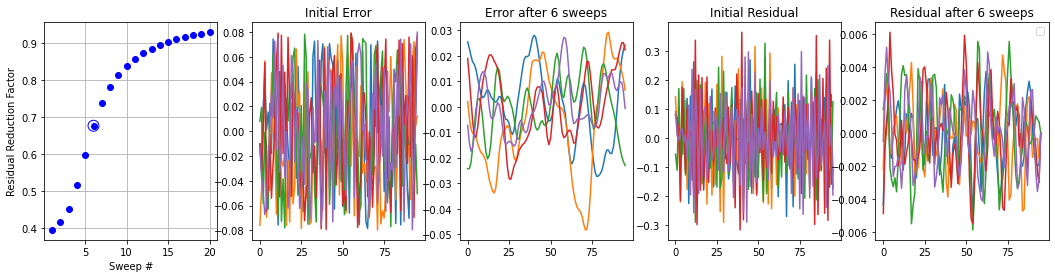

In [214]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

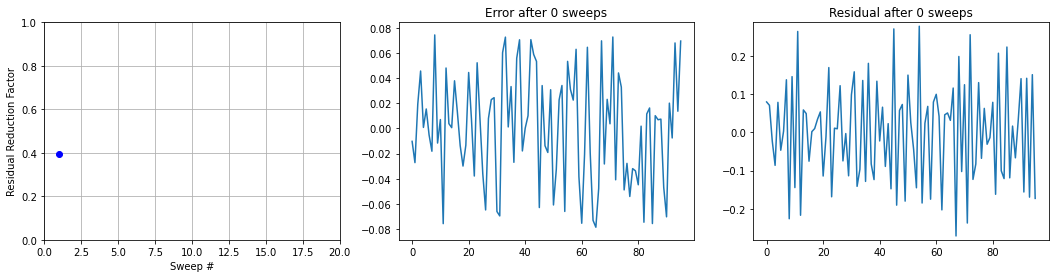

In [215]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [216]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
print("kh", kh)

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

kh 0.5233853805513012


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     7.015e-01 (0.566) [0.566]    3.514e-01    2.002 (0.721)
INFO     2     4.137e-01 (0.590) [0.578]    3.063e-01    1.357 (0.678)
INFO     3     2.586e-01 (0.626) [0.594]    2.831e-01    0.919 (0.677)
INFO     4     1.786e-01 (0.691) [0.617]    2.696e-01    0.667 (0.726)
INFO     5     1.359e-01 (0.761) [0.643]    2.603e-01    0.526 (0.788)
INFO     6     1.114e-01 (0.819) [0.670]    2.533e-01    0.442 (0.842)
INFO     7     9.643e-02 (0.864) [0.695]    2.475e-01    0.391 (0.885)
INFO     8     8.616e-02 (0.893) [0.717]    2.426e-01    0.357 (0.911)
INFO     9     7.854e-02 (0.911) [0.736]    2.382e-01    0.331 (0.928)
INFO     10    7.285e-02 (0.927) [0.753]    2.343e-01    0.312 (0.943)
INFO     11    6.842e-02 (0.939) [0.769]    2.307e-01    0.297 (0.953)
INFO     12    6.482e-02 (0.947) [0.782]    2.274e-01    0.286 (0.961)
INFO 

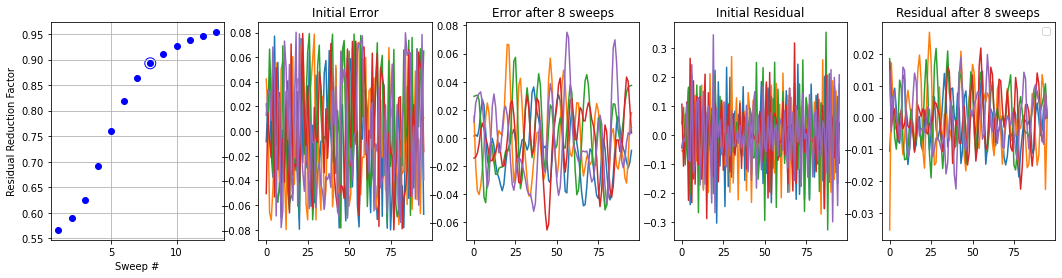

In [217]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

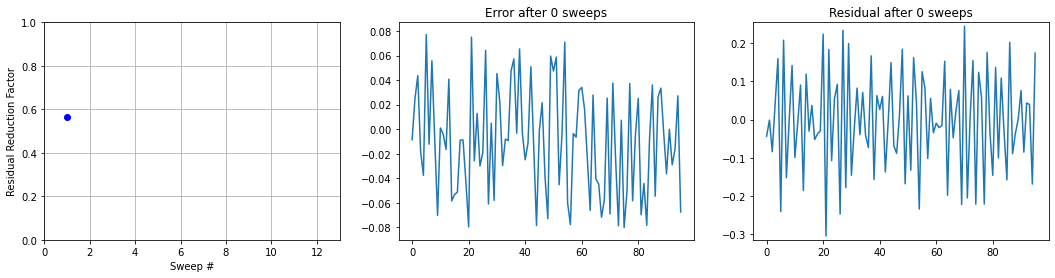

In [218]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("kaczmarz_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [219]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.118


### Coarsening: Fixed (4/2)

In [220]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

nu  30 s [1.    0.624 0.092 0.013] Energy error [0.533 0.078 0.011 0.   ]
INFO     Mock cycle conv [0.597 0.328 0.199 0.153 0.149 0.126 0.087 0.072 0.069 0.064 0.062]


array([[-0.409, -0.538, -0.565, -0.473],
       [-0.7  , -0.265,  0.243,  0.617]])

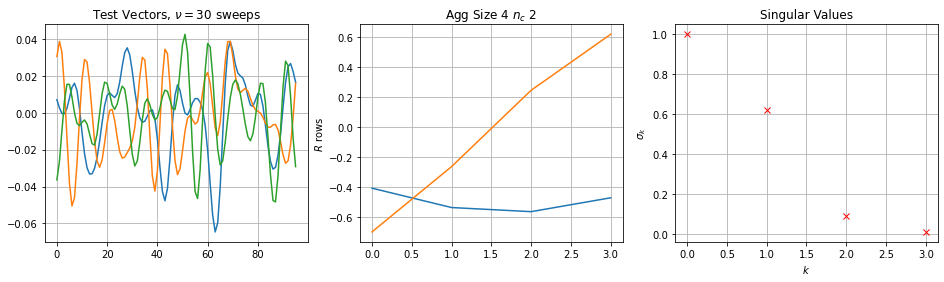

In [221]:
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.4345,-0.5721,-0.5620,-0.4099,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6537,0.2360,-0.2553,-0.6722,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4345,-0.5721,-0.5620,-0.4099,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6537,0.2360,-0.2553,-0.6722,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4345,-0.5721


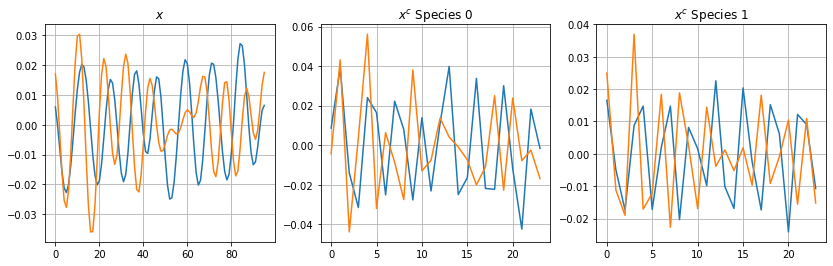

In [222]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with 100 relaxations on the coarse level.

In [224]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 400 # -1
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.119


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.6172,0.3292,0.2013,0.1483,0.1442,0.1337,0.0864,0.0722,0.0689,0.0621,0.0608
P^T A P caliber 2,1.2000,0.0000,0.5316,0.3658,0.4561,0.4837,0.4336,0.4228,0.4156,0.4134,0.3938,0.3918,0.3747
P^T A P caliber 3,1.4000,0.0000,0.6124,0.3457,0.2999,0.3512,0.2908,0.2620,0.2858,0.2774,0.2625,0.2541,0.2560
P^T A P caliber 4,2.0000,0.0000,0.5931,0.3303,0.2177,0.1346,0.1586,0.1379,0.0979,0.0789,0.0739,0.0634,0.0578
Q A P caliber 4,1.2000,0.0000,1.5808,0.6044,0.3605,0.2184,0.2369,0.1528,0.1162,0.0983,0.0811,0.0728,0.0681
R A P caliber 4,1.2000,0.0050,1.6788,0.5457,0.4451,0.2076,0.1958,0.1430,0.1185,0.0831,0.0597,0.0520,0.0369


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [155]:
# for use_r_as_restriction in (False, True):

#     print("R*A*P" if use_r_as_restriction else "P^T*A*P")
#     for caliber in calibers:
#         p = p_caliber[caliber]
#         ml = hm.repetitive.locality.create_two_level_hierarchy(
#             kh, discretization, n, r, p, r if use_r_as_restriction else p.T, aggregate_size, num_components)
#         ac = ml[1].a
#         print("caliber {} P".format(caliber))
#         display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
#         print("A^1")
#         display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))

In [156]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_caliber[4]

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.661e+01           2.424           10.980
INFO     1      3.016e+00  (0.113)  1.205  (0.497)  2.502
INFO     2      4.279e-01  (0.142)  0.233  (0.193)  1.837
INFO     3      1.504e-01  (0.352)  0.093  (0.401)  1.610
INFO     4      1.019e-01  (0.677)  0.069  (0.742)  1.469
INFO     5      8.391e-02  (0.824)  0.061  (0.885)  1.366
INFO     6      7.338e-02  (0.874)  0.057  (0.931)  1.284
INFO     7      6.649e-02  (0.906)  0.055  (0.959)  1.213
INFO     8      6.153e-02  (0.925)  0.054  (0.977)  1.149
INFO     9      5.759e-02  (0.936)  0.053  (0.986)  1.091
INFO     10     5.425e-02  (0.942)  0.052  (0.991)  1.037
INFO     11     5.127e-02  (0.945)  0.052  (0.994)  0.986
INFO     12     4.854e-02  (0.947)  0.052  (0.995)  0.938
INFO     13     4.601e-02  (0.948)  0.052  (0.996)  0.893
INFO     14     4.363e-02  (0.948)  0.051  (0.996)  0.850
INFO     15     4.140e-02  (0.949)  0.051  (0.996)  0.810
INFO     16 

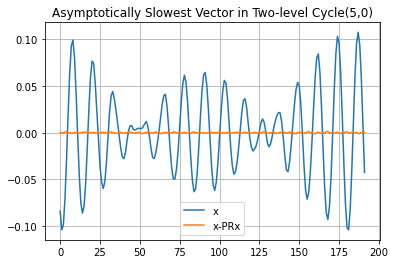

In [169]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, nu_post=0, nu_coarsest=5, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [170]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.    -0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087]
1 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087]


In [171]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,-0.0833,1.3333,-2.2592,1.3333,-0.0833,0.0000
1,0.0000,-0.0833,1.3333,-2.2592,1.3333,-0.0833


In [172]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.1494,-0.1591,-0.0639,0.0099,0.1494,0.1726
1,0.1726,-0.1494,0.0099,-0.6422,-0.1591,-0.1494


In [173]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [174]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [175]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.465e-01                    4.470e-01    0.552
INFO     1     9.435e-02 (0.388) [0.388]    2.768e-01    0.342 (0.627)
INFO     2     5.337e-02 (0.571) [0.466]    2.135e-01    0.251 (0.739)
INFO     3     3.229e-02 (0.606) [0.509]    1.832e-01    0.177 (0.707)
INFO     4     2.400e-02 (0.742) [0.560]    1.654e-01    0.146 (0.823)
INFO     5     1.884e-02 (0.784) [0.599]    1.538e-01    0.124 (0.844)
INFO     6     1.563e-02 (0.829) [0.632]    1.455e-01    0.109 (0.877)
INFO     7     1.352e-02 (0.865) [0.661]    1.392e-01    0.098 (0.905)
INFO     8     1.201e-02 (0.888) [0.686]    1.342e-01    0.091 (0.923)
INFO     9     1.087e-02 (0.905) [0.707]    1.299e-01    0.085 (0.936)
INFO     10    9.978e-03 (0.918) [0.726]    1.262e-01    0.080 (0.945)
INFO     11    9.259e-03 (0.927) [0.742]    1.229e-01    0.076 (0.952)
INFO     12    8.663e-03 (0.935) [0.757]    1.200e-01    0.073 (0.958)
INFO 

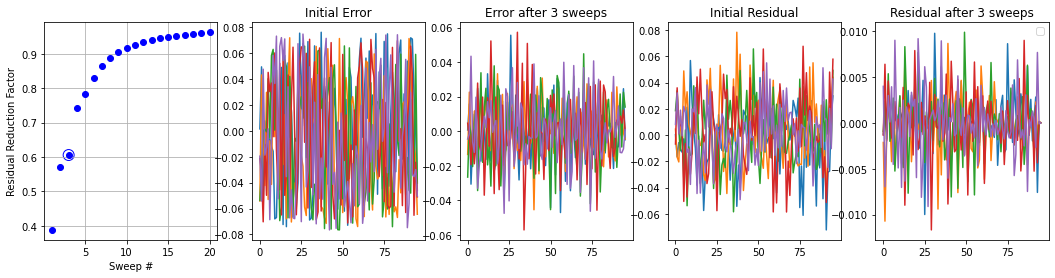

In [176]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

nu 100 s [1.    0.814 0.047 0.004] Energy error [0.632 0.036 0.003 0.   ]
INFO     Mock cycle conv [0.377 0.21  0.127 0.103 0.09  0.079 0.075 0.065 0.052 0.058 0.052]


array([[ 0.65 ,  0.273, -0.668,  0.239],
       [ 0.545, -0.458,  0.514,  0.478]])

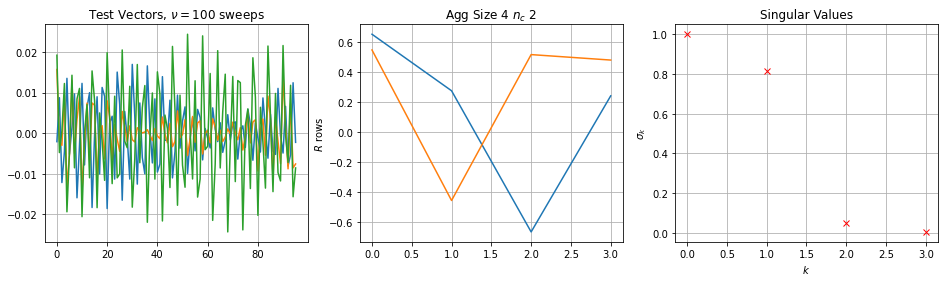

In [177]:
# #PCs revealed by relaxed vectors of increasing smoothness.
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [178]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1494,-0.1591,-0.0639,0.0099,0.1494,0.1726
1,0.1726,-0.1494,0.0099,-0.6422,-0.1591,-0.1494


In [179]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.020


[1.    0.851 0.06  0.005]
(48, 96)


,0,1,2,3,4,5,6,7,8,9
0,-0.6456,-0.2801,0.6709,-0.2339,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.5474,0.4615,-0.5029,-0.4842,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.6456,-0.2801,0.6709,-0.2339,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.5474,0.4615,-0.5029,-0.4842,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6456,-0.2801


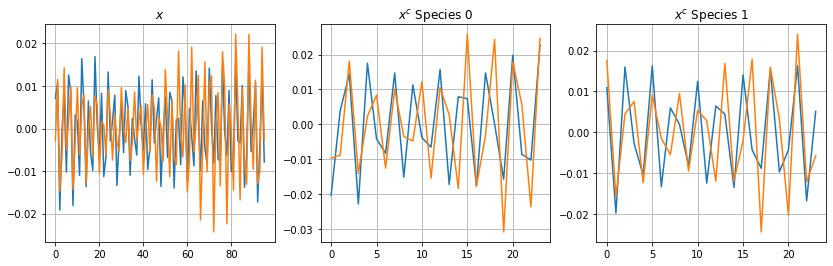

In [180]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with an exact solver on the coarse level.

In [181]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 100
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.024


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3816,0.1956,0.1155,0.0858,0.0697,0.0619,0.0569,0.0557,0.0463,0.0440,0.0346
P^T A P caliber 2,1.0000,0.0000,7.5357,9.5136,7.3857,3.9782,2.5007,1.9285,1.6401,1.4174,1.2175,1.1518,1.0679
P^T A P caliber 3,1.1667,0.0000,0.8607,0.5538,0.3153,0.3442,0.3470,0.3478,0.3484,0.3490,0.3485,0.3495,0.3494
P^T A P caliber 4,1.6667,0.0000,5.4279,3.0244,1.7478,1.2498,0.8346,0.5732,0.3962,0.2747,0.1896,0.1339,0.0949
Q A P caliber 4,1.0000,0.0000,7.5470,4.4421,1.7567,0.5616,0.4729,0.4888,0.4817,0.4932,0.4949,0.4951,0.5059
R A P caliber 4,1.0000,0.0263,3.0276,1.8381,0.6781,0.2582,0.2739,0.2780,0.2665,0.2628,0.2592,0.2553,0.2521


Now, calculate the rates with 100 relaxations at the coarse level.

In [182]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = 10
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.027


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3870,0.2181,0.1270,0.0989,0.0918,0.0776,0.0718,0.0670,0.0652,0.0517,0.0431
P^T A P caliber 2,1.0000,0.0000,4.1081,2.4074,1.7855,1.7698,1.5872,1.3841,1.4369,1.3379,1.2943,1.2710,1.2498
P^T A P caliber 3,1.1667,0.0000,0.9051,0.9973,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999
P^T A P caliber 4,1.6667,0.0000,0.7713,0.9995,0.9995,0.9994,0.9993,0.9993,0.9992,0.9992,0.9992,0.9991,0.9991
Q A P caliber 4,1.0000,0.0000,2.7240,1.4438,0.9756,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998
R A P caliber 4,1.0000,0.0110,2.5593,1.4808,0.9177,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998,0.9998


### Solving $Ax = b$ - Convergence History
If we don't solve exactly at the coarsest level, the cycle stalls.

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.067e+01           2.477           8.345
INFO     1      2.498e+00  (0.121)  1.505  (0.607)  1.660
INFO     2      4.132e-01  (0.165)  0.382  (0.254)  1.081
INFO     3      9.742e-02  (0.236)  0.105  (0.274)  0.929
INFO     4      5.783e-02  (0.594)  0.069  (0.657)  0.840
INFO     5      4.460e-02  (0.771)  0.057  (0.829)  0.781
INFO     6      3.514e-02  (0.788)  0.047  (0.829)  0.743
INFO     7      2.776e-02  (0.790)  0.039  (0.817)  0.718
INFO     8      2.196e-02  (0.791)  0.031  (0.809)  0.702
INFO     9      1.737e-02  (0.791)  0.025  (0.803)  0.692
INFO     10     1.375e-02  (0.791)  0.020  (0.799)  0.686
INFO     11     1.088e-02  (0.791)  0.016  (0.796)  0.682
INFO     12     8.605e-03  (0.791)  0.013  (0.794)  0.680
INFO     13     6.805e-03  (0.791)  0.010  (0.793)  0.678
INFO     14     5.380e-03  (0.791)  0.008  (0.792)  0.677
INFO     15     4.252e-03  (0.790)  0.006  (0.791)  0.677
INFO     16  

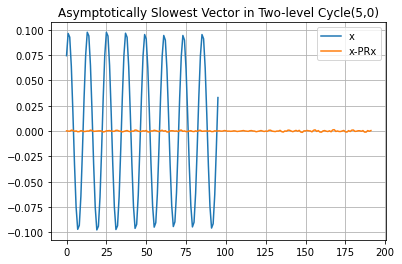

In [230]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
p = p_caliber[4] # P^T*A*P P high order

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, q, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1, nu_coarsest=5,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Level 2 relaxation shrinkage
Relaxation does converge.

Finest level 48
INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     4.384e-02                    4.470e-01    0.098
INFO     1     1.770e-02 (0.413) [0.413]    2.736e-01    0.065 (0.673)
INFO     2     1.071e-02 (0.609) [0.498]    2.180e-01    0.049 (0.765)
INFO     3     7.399e-03 (0.693) [0.556]    1.880e-01    0.040 (0.806)
INFO     4     5.683e-03 (0.769) [0.603]    1.689e-01    0.034 (0.858)
INFO     5     4.615e-03 (0.813) [0.639]    1.555e-01    0.030 (0.885)
INFO     6     3.890e-03 (0.844) [0.669]    1.456e-01    0.027 (0.903)
INFO     7     3.368e-03 (0.866) [0.694]    1.379e-01    0.025 (0.915)
INFO     8     2.971e-03 (0.880) [0.715]    1.318e-01    0.023 (0.922)
INFO     9     2.657e-03 (0.891) [0.732]    1.268e-01    0.021 (0.926)
INFO     10    2.403e-03 (0.899) [0.748]    1.226e-01    0.020 (0.930)
INFO     11    2.191e-03 (0.905) [0.761]    1.191e-01    0.018 (0.932)
INFO     12    2.013e-03 (0.911) [0.773]    1.161e-01    0.0

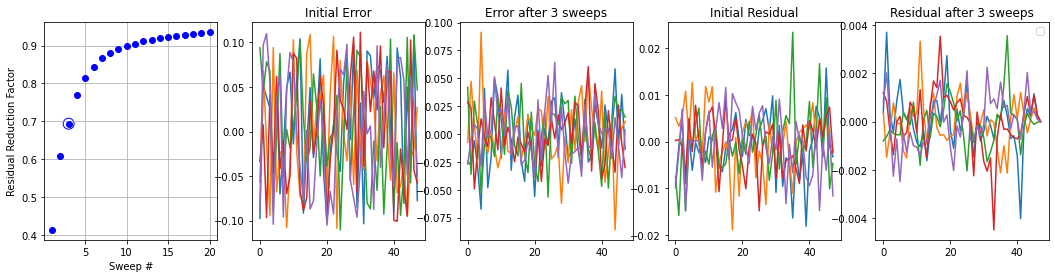

In [191]:
m2 = m1.sub_hierarchy(1)
print("Finest level", m2[0].size)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m2, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

In [192]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,-0.6456,-0.2801,0.6709,-0.2339
1,-0.5474,0.4615,-0.5029,-0.4842


In [193]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12], lam[0])

0 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087] -0.00021123907123728154
1 lam [-0.    -0.     0.008  0.008 -0.016 -0.016  0.031  0.031  0.034  0.034 -0.035 -0.035] -4.6699393278342084e-05


## 3-Level Method
With $Q A P$ coarsening at level $0$ and $R A P$ at leve1 1.

In [194]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(m0[0])
ml.add(m0[1])
ml.add(m1[1])

In [235]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu_pre, nu_post=nu_post, print_frequency=1, debug=False,
                                                   nu_coarsest=20)

# Asymptotic vector.
#plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# # y -= y.mean() # Remove zero component.
# # e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.930e+01           2.502           11.708
INFO     1      1.148e+00  (0.039)  0.589  (0.235)  1.950
INFO     2      9.768e-02  (0.085)  0.058  (0.099)  1.684
INFO     3      7.849e-03  (0.080)  0.005  (0.080)  1.683
INFO     4      7.346e-04  (0.094)  0.000  (0.094)  1.683
INFO     5      7.983e-05  (0.109)  0.000  (0.109)  1.683
INFO     6      8.847e-06  (0.111)  0.000  (0.111)  1.683
INFO     7      1.021e-06  (0.115)  0.000  (0.115)  1.683
INFO     8      1.179e-07  (0.115)  0.000  (0.115)  1.683
INFO     9      1.358e-08  (0.115)  0.000  (0.115)  1.683
INFO     10     1.580e-09  (0.116)  0.000  (0.116)  1.683
INFO     11     1.838e-10  (0.116)  0.000  (0.116)  1.683
INFO     12     2.127e-11  (0.116)  0.000  (0.116)  1.683


In [202]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(ml)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:21])

0 lam [-0.    -0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087 -0.106 -0.106  0.111  0.111  0.134  0.134 -0.145 -0.145  0.154]
1 lam [-0.    -0.     0.031  0.031 -0.034 -0.034  0.06   0.06  -0.069 -0.069  0.087  0.087 -0.106 -0.106  0.112  0.112  0.134  0.134 -0.145 -0.145  0.154]
2 lam [-0.    -0.     0.008  0.008 -0.016 -0.016  0.031  0.031  0.034  0.034 -0.035 -0.035 -0.036 -0.036 -0.048 -0.048 -0.052  0.054  0.054  0.06   0.06 ]


In [130]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

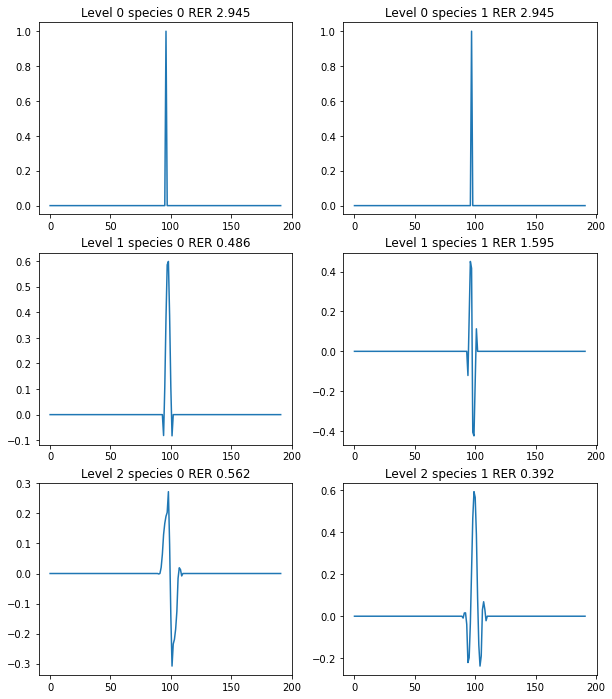

In [210]:
fig, axs = plt.subplots(len(ml), num_components, figsize=(10, 4 * len(ml)))

for l in range(len(ml)):
    m = ml[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = ml[ll]._p.dot(u)
        axs[l, col].set_title("Level {} species {} RER {:.3f}".format(l, col, norm(ml[0].operator(u)) / norm(u)))
        axs[l, col].plot(u);